<a href="https://www.kaggle.com/code/midojr/dogs-vs-cats-with-cnn?scriptVersionId=92416851" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


# Contents
In This NoteBook , we will follow these 

1. Explore the example data of Dogs vs. Cats
1. Build and train a neural network to classify between the two pets
1. Evaluate the training and validation accuracy

# Explore the data of Dogs vs. Cats

In [2]:
import os
import zipfile
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import RMSprop


In [3]:
work_path = './cats_and_dogs_filtered'
os.mkdir(work_path)

In [4]:

local_zip = '../input/dogs-vs-cats/test1.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall(work_path)

local_zip = '../input/dogs-vs-cats/train.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall(work_path)

zip_ref.close()

In [5]:
train_path = os.path.join(work_path, 'train')
test_path = os.path.join(work_path, 'test1')

In [6]:
train_df = pd.DataFrame({'image_name':os.listdir(train_path)})
train_df['label'] =train_df['image_name'].apply(lambda x: x.split('.')[0])
train_df

,image_name,label
0,cat.3135.jpg,cat
1,dog.1079.jpg,dog
2,dog.10049.jpg,dog
3,dog.794.jpg,dog
4,dog.781.jpg,dog
...,...,...
24995,dog.6658.jpg,dog
24996,cat.5249.jpg,cat
24997,cat.5233.jpg,cat
24998,dog.11647.jpg,dog


In [7]:
test_df = pd.DataFrame({'image_name':os.listdir(test_path)})
test_df['label'] =test_df['image_name'].apply(lambda x: x.split('.')[0])
test_df

,image_name,label
0,9413.jpg,9413
1,9389.jpg,9389
2,10936.jpg,10936
3,2381.jpg,2381
4,10849.jpg,10849
...,...,...
12495,8726.jpg,8726
12496,315.jpg,315
12497,3118.jpg,3118
12498,1846.jpg,1846


# Tidying up the data


### Arrange Training in sub-directories

In [8]:
dog_path_train = os.path.join(train_path, 'dog')
os.mkdir(dog_path_train)
dog_df_train = train_df[train_df.label=='dog']
for n in tqdm(dog_df_train.image_name):
    os.rename((os.path.join(train_path, n)), (os.path.join(dog_path_train, n)))

100%|██████████| 12500/12500 [00:00<00:00, 41615.41it/s]


In [9]:
cat_path_train = os.path.join(train_path, 'cat')
os.mkdir(cat_path_train)
cat_df_train = train_df[train_df.label=='cat']
for n in tqdm(cat_df_train.image_name):
    os.rename((os.path.join(train_path, n)), (os.path.join(cat_path_train, n)))

100%|██████████| 12500/12500 [00:00<00:00, 43482.85it/s]


### check subdirectories

In [10]:
# # check subdirectories
base_dir = './cats_and_dogs_filtered'

print(' Contents of base directory')
print(os.listdir(base_dir))

print('\n Contents of Train directory')
train_path = f'{base_dir}/train'
print(os.listdir(train_path))

print('\n Contents of validation directory')
print(os.listdir(test_path)[:5])

 Contents of base directory
['train', 'test1']

 Contents of Train directory
['cat', 'dog']

 Contents of validation directory
['9413.jpg', '9389.jpg', '10936.jpg', '2381.jpg', '10849.jpg']


### assign each dir to a varibles

In [11]:
# assign each dir to a varibles
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'test1')

train_cats_dir = os.path.join(train_dir,'cat')
train_dogs_dir = os.path.join(train_dir,'dog')

In [12]:
# see the filenames look like 
train_cats_names = os.listdir(train_cats_dir)
train_dogs_names = os.listdir(train_dogs_dir)

print(train_cats_names[:5])
print(train_dogs_names[:5])

['cat.3135.jpg', 'cat.11973.jpg', 'cat.5937.jpg', 'cat.9039.jpg', 'cat.862.jpg']
['dog.1079.jpg', 'dog.10049.jpg', 'dog.794.jpg', 'dog.781.jpg', 'dog.6768.jpg']


### number of cats and dogs

In [13]:
# total number of cats and dogs in training set and validation set
print(f'numbers of cats in training set = {len(train_cats_names)}')
print(f'numbers of dogs in training set = {len(train_dogs_names)}')
print(f'numbers of cats and dogs in validation set = {len(os.listdir(validation_dir))}')

numbers of cats in training set = 12500
numbers of dogs in training set = 12500
numbers of cats and dogs in validation set = 12500


# Take a look at a few images

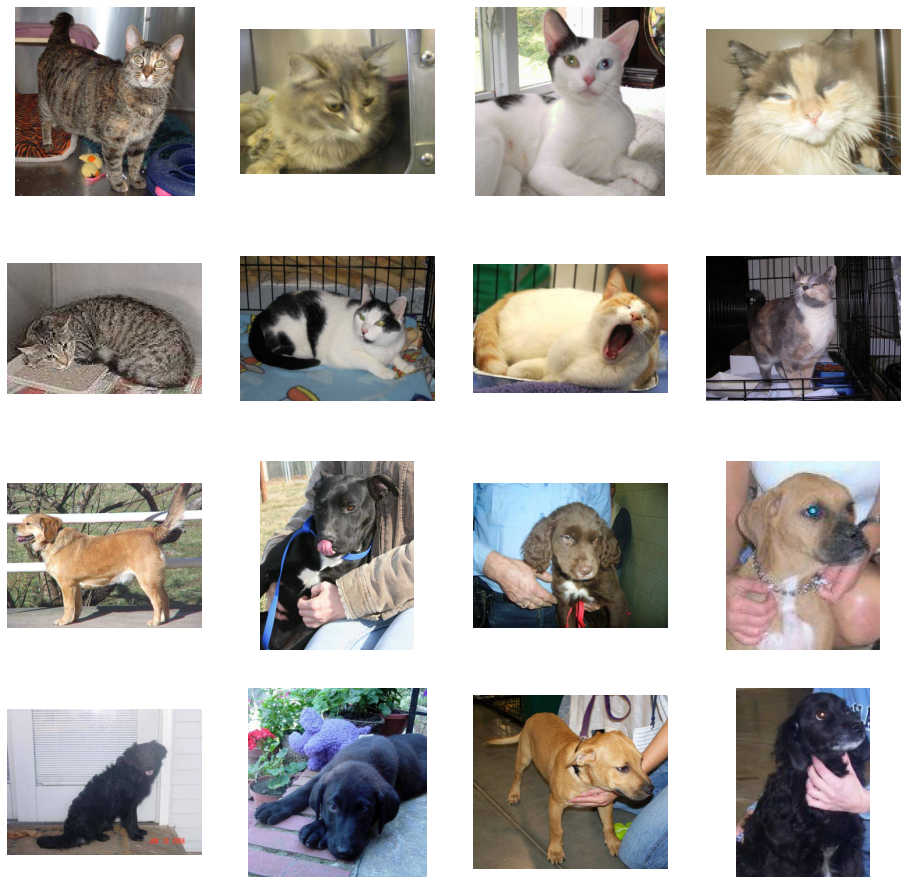

In [14]:
# take a look at a few images
%matplotlib inline

nrows = 4
ncols = 4

pic_index = 0

fig = plt.gcf()
fig.set_size_inches(nrows*4,ncols*4)

next_cat_pic = [os.path.join(train_cats_dir,fname) for fname in train_cats_names[pic_index:pic_index+8]]

next_dog_pic = [os.path.join(train_dogs_dir,fname) for fname in train_dogs_names[pic_index:pic_index+8]]

for i ,img_path in enumerate(next_cat_pic+next_dog_pic):
    sp = plt.subplot(nrows,ncols,i+1)
    sp.axis('off')
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()    
    

# Building a model from scratch

In [15]:
def create_model():

  model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(16,(3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  
  model.compile(optimizer=RMSprop(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']) 
    
  return model


In [16]:
model = create_model()
model.summary()

2022-04-08 03:53:46.062532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 03:53:46.157431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 03:53:46.158141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 03:53:46.159407: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

node zero
2022-04-08 03:53:46.161447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 03:53:46.162321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 03:53:48.186868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 03:53:48.187684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 03:53:48.188369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

# ImageDataGenrator

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255,
    validation_split=0.3
                                  ) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=50,
    class_mode='binary',
    subset='training'
) # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(150, 150),
    batch_size=50,
    class_mode='binary',
    subset='validation') # set as validation data


Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [18]:
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('val_accuracy')>=0.90):
            self.model.stop_training = True
            
callback = mycallback()
            
            

# Model Training

In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples//50,#batch_size, 
    epochs = 5,
    verbose=1,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples//50,#batch_size,
    callbacks=[callback]
)

2022-04-08 03:53:50.682177: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-04-08 03:53:52.242029: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


350/350 [==============================] - 72s 186ms/step - loss: 0.6060 - accuracy: 0.6757 - val_loss: 0.5677 - val_accuracy: 0.7180
Epoch 2/5
350/350 [==============================] - 64s 181ms/step - loss: 0.4816 - accuracy: 0.7714 - val_loss: 0.4481 - val_accuracy: 0.7920
Epoch 3/5
350/350 [==============================] - 64s 181ms/step - loss: 0.4082 - accuracy: 0.8133 - val_loss: 0.4104 - val_accuracy: 0.8165
Epoch 4/5
350/350 [==============================] - 63s 181ms/step - loss: 0.3457 - accuracy: 0.8507 - val_loss: 0.4157 - val_accuracy: 0.8125
Epoch 5/5
350/350 [==============================] - 64s 182ms/step - loss: 0.2752 - accuracy: 0.8814 - val_loss: 0.4753 - val_accuracy: 0.8064


# Validation accuracy

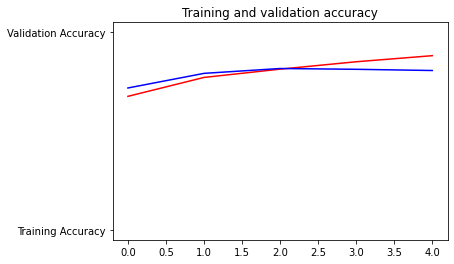

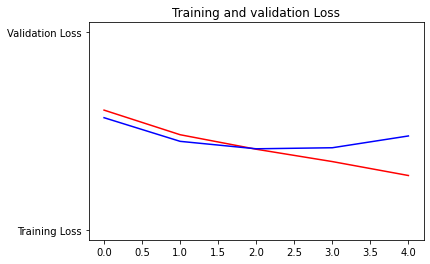

In [20]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()

# Plot training and validation loss per epoch

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.title('Training and validation Loss')
plt.show()